## Mall Customers

In [25]:
# Imports necessary to acquire, prepare, explore, visualize, analyze, and model data

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import prepare
import wrangle_mall

from tabulate import tabulate
from IPython.display import Markdown, display

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

np.random.seed(123)

In [9]:
from env import host, user, password

url = f'mysql+pymysql://{user}:{password}@{host}/mall_customers'

In [12]:
sql = """
        SELECT *
        FROM customers;

        """
df = pd.read_sql(sql, url)

In [13]:
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [14]:
df.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


array([[<AxesSubplot:title={'center':'customer_id'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'annual_income'}>,
        <AxesSubplot:title={'center':'spending_score'}>]], dtype=object)

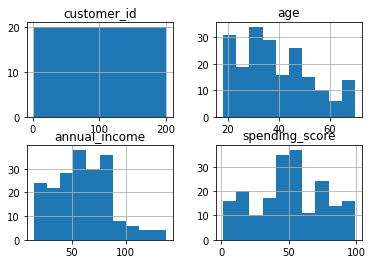

In [16]:
df.hist()

In [19]:
df.isna().sum() #no nulls

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [20]:
def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    # outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
    #                 for col in df.select_dtypes('number')}
    # return df.assign(**outlier_cols)

    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

add_upper_outlier_columns(df, k=1.5)

df.head()

,customer_id,gender,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers
0,1,Male,19,15,39,0,0,0.0,0
1,2,Male,21,15,81,0,0,0.0,0
2,3,Female,20,16,6,0,0,0.0,0
3,4,Female,23,16,77,0,0,0.0,0
4,5,Female,31,17,40,0,0,0.0,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              200 non-null    int64  
 1   gender                   200 non-null    object 
 2   age                      200 non-null    int64  
 3   annual_income            200 non-null    int64  
 4   spending_score           200 non-null    int64  
 5   customer_id_outliers     200 non-null    int64  
 6   age_outliers             200 non-null    int64  
 7   annual_income_outliers   200 non-null    float64
 8   spending_score_outliers  200 non-null    int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 14.2+ KB


In [24]:
outlier_cols = [col for col in df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = df[col][df[col] > 0]
    print(data.describe())

~~~
customer_id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: customer_id_outliers, dtype: float64
~~~
age_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age_outliers, dtype: float64
~~~
annual_income_outliers
count    2.00
mean     4.25
std      0.00
min      4.25
25%      4.25
50%      4.25
75%      4.25
max      4.25
Name: annual_income_outliers, dtype: float64
~~~
spending_score_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: spending_score_outliers, dtype: float64
